In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
%matplotlib inline

In [34]:
data = pd.read_csv('sparse_train.csv')
data['boxes'] = data['boxes'].apply(ast.literal_eval)

In [35]:
def compute_new_static_size(width, height, min_dimension, max_dimension):
    """Computes the new size of an image, given the minimum and maximum dimensions.

    Args:
        width: The width of the image.
        height: The height of the image.
        min_dimension: The minimum dimension of the image.
        max_dimension: The maximum dimension of the image.

    Returns:
        The new size of the image.
    """

    min_dim = min(width, height)
    max_dim = max(width, height)

    # Calculates the scale factor.
    scale_factor = min_dimension / float(min_dim)

    # Calculates the new width and height.
    new_width = int(round(width * scale_factor))
    new_height = int(round(height * scale_factor))

    # Checks if the new size is too large.
    if max_dimension and max(new_width, new_height) > max_dimension:
        # Calculates the scale factor for the maximum dimension.
        scale_factor = max_dimension / float(max_dim)

        # Calculates the new width and height.
        new_width = int(round(width * scale_factor))
        new_height = int(round(height * scale_factor))

    return new_width, new_height


In [36]:
data.loc[:, 'box_width'] = data['boxes'].apply(lambda x: x[2] - x[0] + 1)
data.loc[:, 'box_height'] = data['boxes'].apply(lambda x: x[3] - x[1] + 1)

In [37]:
min_dimension = 800
max_dimension = 1024

data['new_w'], data['new_h'] = np.vectorize(compute_new_static_size)(data['width'], 
                                                                      data['height'], min_dimension, max_dimension)
data['b_w'] = data['new_w']*data['box_width']/data['width']
data['b_h'] = data['new_h']*data['box_height']/data['height']
data['b_ar'] = data['b_h']/data['b_w']

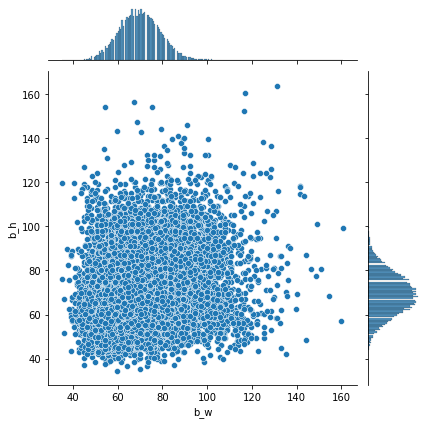

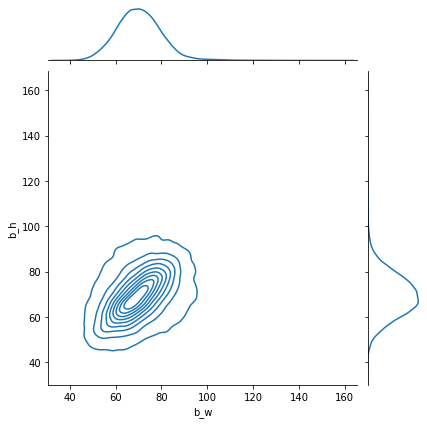

In [38]:
sns.jointplot(x="b_w", y="b_h", data=data)
sns.jointplot(x="b_w", y="b_h", data=data, kind='kde')

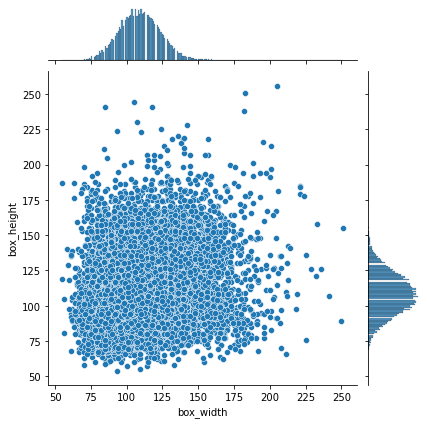

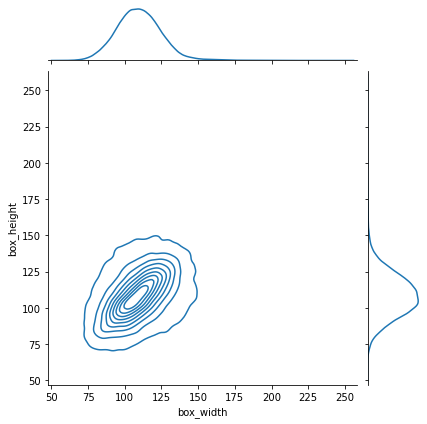

In [39]:
sns.jointplot(x="box_width", y="box_height", data=data)
sns.jointplot(x="box_width", y="box_height", data=data, kind='kde')

In [40]:
def calculate_iou(box1, box2):
    """
    Calculates the IOU of two bounding boxes.

    Args:
        box1 (list): The first bounding box, in the format (xmin, ymin, xmax, ymax).
        box2 (list): The second bounding box, in the format (xmin, ymin, xmax, ymax).

    Returns:
        float: The IOU of the two bounding boxes.
    """

    xmin1, ymin1, xmax1, ymax1 = box1[0], box1[1], box1[2], box1[3] 
    xmin2, ymin2, xmax2, ymax2 = box2[0], box2[1], box2[2], box2[3]

    # Calculate the intersection of the two bounding boxes.
    intersection_xmin = max(xmin1, xmin2)
    intersection_ymin = max(ymin1, ymin2)
    intersection_xmax = min(xmax1, xmax2)
    intersection_ymax = min(ymax1, ymax2)

    # Calculate the area of the intersection.
    intersection_area = max(0, intersection_xmax - intersection_xmin) * max(0, intersection_ymax - intersection_ymin)

    # Calculate the union of the two bounding boxes.
    union_area = (xmax1 - xmin1) * (ymax1 - ymin1) + (xmax2 - xmin2) * (ymax2 - ymin2) - intersection_area

    # Calculate the IOU.
    iou = intersection_area / union_area

    return iou

from sklearn.cluster import KMeans

def initialize_anchor_boxes(boxes, num_anchors):
    # Extract box widths and heights
    widths = [box[2] - box[0] for box in boxes]
    heights = [box[3] - box[1] for box in boxes]
    
    # Stack widths and heights into a feature matrix
    features = np.column_stack((widths, heights))
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_anchors, random_state=0)
    kmeans.fit(features)
    
    # Get the cluster centroids as the anchor boxes
    anchors = kmeans.cluster_centers_
    
    # Convert anchor boxes to xmin, ymin, xmax, ymax format
    anchors = [[0, 0, anchor[0], anchor[1]] for anchor in anchors]
    
    return anchors


def assign_boxes_to_anchors(boxes, anchors):
    assignments = []
    for box in boxes:
        iou_distances = [1 - calculate_iou(box, anchor) for anchor in anchors]
        min_index = np.argmin(iou_distances)
        assignments.append(min_index)
    return assignments

def update_anchor_boxes(boxes, assignments, num_anchors):
    new_anchors = []
    for i in range(num_anchors):
        assigned_boxes = [box for box, index in zip(boxes, assignments) if index == i]
        mean_box = np.mean(assigned_boxes, axis=0)
        new_anchors.append(mean_box)
    return new_anchors

def compute_mean_iou(boxes, anchors, assignments):
    total_iou = 0
    for i, anchor in enumerate(anchors):
        assigned_boxes = [box for box, index in zip(boxes, assignments) if index == i]
        iou_values = [calculate_iou(anchor, box) for box in assigned_boxes]
        mean_iou = np.mean(iou_values)
        total_iou += mean_iou
    return total_iou / len(anchors)



In [41]:
import random
import numpy as np

def estimate_anchor_boxes(boxes, num_anchors, max_iterations=100, min_iou_improvement=1e-4):
    # Initialize the anchor boxes using k-means clustering
    anchors = initialize_anchor_boxes(boxes, num_anchors)
    
    # Initialize the mean IoU to zero
    mean_iou = 0
    
    # Iterate until convergence or maximum iterations
    for iteration in range(max_iterations):
        # Assign each box to the closest anchor based on IoU distance
        assignments = assign_boxes_to_anchors(boxes, anchors)
        
        # Update the anchor boxes by computing the mean of the assigned boxes
        new_anchors = update_anchor_boxes(boxes, assignments, num_anchors)
        
        # Compute the mean IoU of the new anchors and the assigned boxes
        new_mean_iou = compute_mean_iou(boxes, new_anchors, assignments)
        
        # Check if the mean IoU improvement is above the threshold
        if new_mean_iou - mean_iou < min_iou_improvement:
            break
        
        # Update the anchor boxes and mean IoU
        anchors = new_anchors
        mean_iou = new_mean_iou
    
    # Return the final anchor boxes and mean IoU
    return anchors, mean_iou

In [48]:
data['b_w'] = np.ceil(data['b_w']).astype(int)
data['b_h'] = np.ceil(data['b_h']).astype(int)
data.loc[:, 'center_boxes'] = data.apply(lambda row: [0, 0, row[11], row[12]], axis=1)

In [49]:
data.head()

,pathname,height,width,boxes,label,area,aspect_ratio,box_width,box_height,new_w,new_h,b_w,b_h,b_ar,center_boxes
0,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1200,1600,"[1440, 1057, 1540, 1158]",RBC,10100,1.010000,101,102,1024,768,65,66,1.009901,"[0, 0, 65, 66]"
1,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1200,1600,"[1303, 868, 1403, 971]",RBC,10300,1.030000,101,104,1024,768,65,67,1.029703,"[0, 0, 65, 67]"
2,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1200,1600,"[900, 578, 1008, 689]",RBC,11988,1.027778,109,112,1024,768,70,72,1.027523,"[0, 0, 70, 72]"
3,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1200,1600,"[611, 304, 713, 408]",RBC,10608,1.019608,103,105,1024,768,66,68,1.019417,"[0, 0, 66, 68]"
4,/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,1200,1600,"[881, 198, 1003, 312]",RBC,13908,0.934426,123,115,1024,768,79,74,0.934959,"[0, 0, 79, 74]"


In [50]:
anchor_number = []
mean_ious = []
for i in range(2, 15):
    anchors, mean_iou = estimate_anchor_boxes(data['center_boxes'].tolist(), i)
    anchor_number.append(i)
    mean_ious.append(mean_iou)

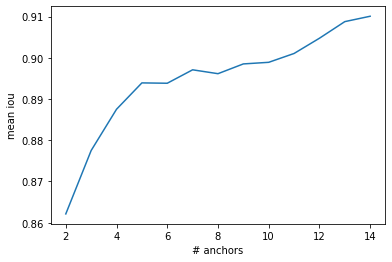

In [51]:
sns.lineplot(x=anchor_number, y=mean_ious)

# Adding labels and title
plt.xlabel('# anchors')
plt.ylabel('mean iou')

# Display the plot
plt.show()

In [55]:
anchors, mean_iou = estimate_anchor_boxes(data['center_boxes'].tolist(), 6)
anchors

[array([ 0.        ,  0.        , 75.90987642, 75.68873706]),
 array([ 0.        ,  0.        , 63.64940732, 74.25881754]),
 array([ 0.        ,  0.        , 59.05615638, 58.95902465]),
 array([ 0.        ,  0.        , 70.64549552, 64.26115112]),
 array([ 0.        ,  0.        , 82.41740764, 87.16380714]),
 array([ 0.        ,  0.        , 90.12683952, 68.48656856])]

In [56]:
anchors = np.array(anchors)
aspect_ratios = np.ceil(anchors[:, 3] / anchors[:, 2])
sizes = np.ceil(anchors[:,2])
print(sizes)
print(aspect_ratios)

[76. 64. 60. 71. 83. 91.]
[1. 2. 1. 1. 2. 1.]


In [57]:
mean_iou

0.893834896239456